# Problem statement
![image](./figures/Aero_Composite_Applications.png)

# Thermoset resin curing
![image](./figures/molleculas.png)

# Data collecting

![image](./figures/DSC_polyma.jpg)
![image](./figures/DSC_incide.jpg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.integrate import simps

%matplotlib inline

Let's start with single measurment analysis. First, load data and plot it.

In [2]:
df = pd.read_csv('data/ExpDat_SK_Clear_resin_entalp5kpm_20-150.txt', sep='\t',comment='#')
df.columns = ['Temp', 'Time', 'DSC', 'Sence']

df.head()

,Temp,Time,DSC,Sence
0,20.01794,0.01,0.022839,3.36733
1,20.01857,0.02,0.022820,3.36733
2,20.02401,0.03,0.022770,3.36734
3,20.03631,0.04,0.022824,3.36735
4,20.05572,0.05,0.023849,3.36737


Text(0.5, 1.0, 'Raw cure kinetics signal by temperature')

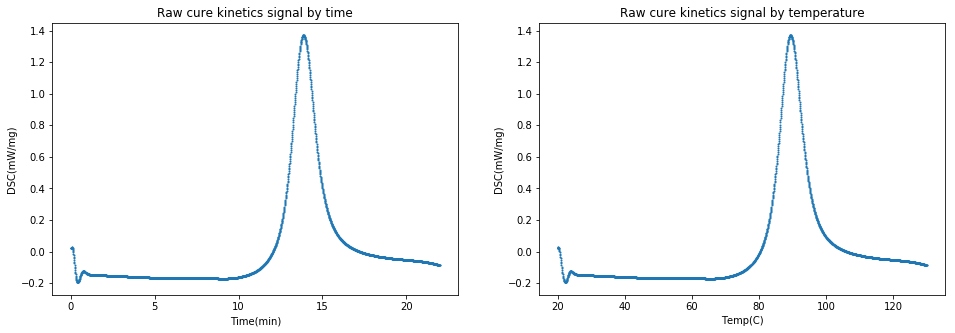

In [3]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].plot(df['Time'], df['DSC'], "o", markersize=1)
ax[0].set_title('Raw cure kinetics signal by time')

ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].plot(df['Temp'], df['DSC'], "o", markersize=1)
ax[1].set_title('Raw cure kinetics signal by temperature')

#  Preprocessing of data
Here we separate the polymerization enthalpy of the resin from the rest of the data. We shall to calculate baseline and put peak of curig on "ox" axe and integrate it. Quantity of partial integration of heat per time in total heat gives us cure degree allow us to calc resin cure degee in time or temperature.

$$ \alpha = \frac{H(t)}{H_{total}}$$
Where $H(t)$ current amount of exothermal heat, $H_{total}$ – total exothermal heat of polymerization reaction and $\alpha$ - cure degree

[0.09091179, 0.08824617]


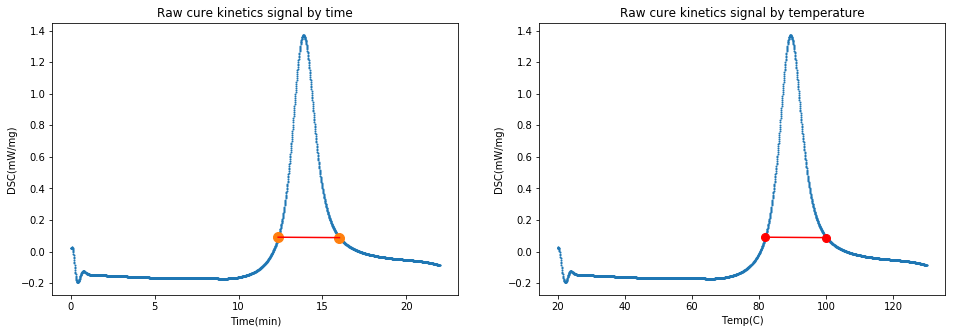

In [4]:
def find_peak(df):
    peaks_positive, _ = find_peaks(df['DSC'], height=1.2)
    peaks_width, width_heights, _, _ = peak_widths(df['DSC'], peaks_positive, rel_height = 0.88)

    peak_start = df['DSC'][df['DSC']>width_heights[0]].first_valid_index()
    peak_end = df['DSC'][df['DSC']>width_heights[0]].last_valid_index()

    print([df['DSC'][peak_start],df['DSC'][peak_end]])

    fig, ax = plt.subplots(1, 2, figsize = (16, 5))
    ax[0].plot(df['Time'], df['DSC'], "o", markersize=1, label = "Signal")
    ax[0].plot([df['Time'][peak_start],df['Time'][peak_end]],
                   [df['DSC'][peak_start],df['DSC'][peak_end]],
                  "o", markersize=10, label = "Baseline")
    ax[0].plot([df['Time'][peak_start],df['Time'][peak_end]],
           [df['DSC'][peak_start],df['DSC'][peak_end]],
            color = "r", label = "Baseline")
    ax[0].set_xlabel("Time(min)")
    ax[0].set_ylabel('DSC(mW/mg)')
    ax[0].set_title('Raw cure kinetics signal by time')

    ax[1].plot(df['Temp'], df['DSC'], "o", markersize=1, label = "Signal")
    ax[1].plot([df['Temp'][peak_start],df['Temp'][peak_end]],
                   [df['DSC'][peak_start],df['DSC'][peak_end]],
                    "o", markersize=8, color = "r", label = "Baseline")
    ax[1].plot([df['Temp'][peak_start],df['Temp'][peak_end]],
               [df['DSC'][peak_start],df['DSC'][peak_end]],
                color = "r", label = "Baseline")
    ax[1].set_xlabel("Temp(C)")
    ax[1].set_ylabel('DSC(mW/mg)')
    ax[1].set_title('Raw cure kinetics signal by temperature')
    
    return peak_start, peak_end

peak_start, peak_end = find_peak(df)

Строим бейслайн по точкам начала и конца, режем пик, приводим к бейслайну

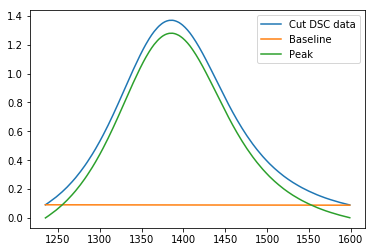

In [5]:
def calc_peak(df, peak_start, peak_end):
    baseline = np.zeros(0)

    for i in range(peak_end - peak_start):  # строим baseline
        new_val = (df['DSC'][peak_end] - df['DSC'][peak_start])/(peak_end - peak_start)*i + df['DSC'][peak_start]
        baseline = np.append(baseline,new_val)

    peak = df['DSC'][peak_start: peak_end] - baseline
    
    return peak, baseline

peak, baseline = calc_peak(df, peak_start, peak_end)

plt.plot(df['DSC'][peak_start: peak_end], label = "Cut DSC data")
plt.plot(range(peak_start, peak_end), baseline, label = "Baseline")
plt.plot(range(peak_start, peak_end), peak, label = "Peak")
plt.legend()
plt.show()

Now we ready to construct cure degree

Text(0, 0.5, 'Cure degree')

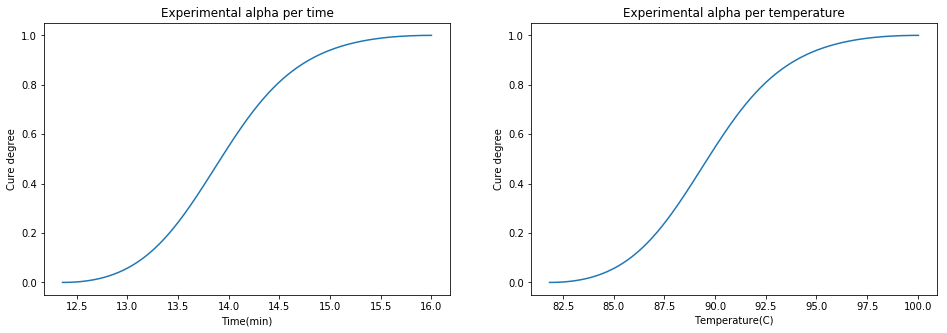

In [6]:
def calc_alpha(peak):
    spent_energy = simps(peak)
    alpha = []

    for i,_ in enumerate(peak):
        alpha.append(simps(peak[:i+1])/spent_energy)    
    return alpha

alpha = calc_alpha(peak)

fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(df["Time"][peak_start:peak_end], alpha)
ax[0].set_title("Experimental alpha per time")
ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel("Cure degree")

ax[1].plot(df["Temp"][peak_start:peak_end], alpha)
ax[1].set_title("Experimental alpha per temperature")
ax[1].set_xlabel("Temperature(C)")
ax[1].set_ylabel("Cure degree")

# Classic ways to simulate resin curing

Modern focilities calculate cure degree with based on Arrenius equation models. The most popular equation for pultrusion facilities is Prout-Tomkiense model:

$$\frac{d\alpha}{dt} = Ae^{-\frac{E_a}{RT}}(1-\alpha)^n \alpha^m$$

Where:
* $E_a$ - activation energy
* $R$ - gas constant = 8.314
* $T$ - temperature in Kelvin
* $A$, $m$ and $n$ - resin cure characteristics
* $\alpha$ - current cure degree

The easiest way to solve the equation - logarithm it.

$$\ln(\frac{d\alpha}{dt}) = \ln(A) - \frac{E_a}{RT} + n \ln(1-\alpha) + m \ln(\alpha)$$

We can use multilinnear regression, to find coefficients
We know the temperature at which the reaction takes place. We can determine the search parameters based on known data, construct a regression, and then obtain its coefficients. These coefficients will be the unknown parameters of the resin.

In [7]:
def extract_data(df, peak_start, peak_end, alpha):

    dt = []
    dalpha = []
    dalpha_dt = []
    temp = []
    dtemp = []
    dalpha_dtemp = []

    for i in range(peak_end - peak_start):
        dt.append((df['Time'][i+1] - df['Time'][i]) * 60)
        temp.append(df['Temp'][i] + 237)
        dtemp.append(df['Temp'][i+1] - df['Temp'][i])

    dalpha.append(0)
    for i in range(len(alpha)-1):
        dalpha.append(alpha[i+1] - alpha[i])

    for i in range(len(dalpha)):
        dalpha_dt.append(dalpha[i]/dt[i])

    for i in range(len(dalpha)):
        dalpha_dtemp.append(dalpha[i]/dtemp[i])

    data = {'alpha' : alpha, 
            'dtime' : dt, 
            'dalpha' : dalpha, 
            'dalpha_dtime' : dalpha_dt, 
            'time' : df['Time'][peak_start:peak_end], 
            'peak' : peak,
            'temp' : temp,
            'dtemp' : dtemp,#разве что как фича для новых регрессий
            'dalpha_dtemp' : dalpha_dtemp,
           }

    processed_df = pd.DataFrame(data, columns = ['alpha', 'dtime', 'dalpha', 'dalpha_dtime', 'time', 'peak', 'temp', 'dtemp', 'dalpha_dtemp'])
    processed_df.drop(processed_df.head(1).index, inplace=True)
    processed_df.drop(processed_df.tail(1).index, inplace=True)
    processed_df.head()
    
    return processed_df

In [8]:
from sklearn import linear_model

processed_df = extract_data(df, peak_start, peak_end, alpha)

R = 8.314

a = np.ones(processed_df['alpha'].count()) #собираем матрицу коэффицентов
b = np.array(-1 / (R * processed_df['temp']))
c = np.array(np.log(1 - processed_df['alpha']))
d = np.log(processed_df['alpha'])
X = np.vstack([a, b, c, d])
#X = np.vstack([a, b, c])
X = X.transpose()

y = np.log(processed_df['dalpha_dtime'])

lm_regr = linear_model.LinearRegression(fit_intercept=False, normalize=True)
lm_regr.fit(X, y)

print("These coefficients are fully describe the nature of the polymerization:")
print("A = ", np.exp(lm_regr.coef_[0]))
print("E_a = ", lm_regr.coef_[1])
print("n = ", lm_regr.coef_[2])
print("m =", lm_regr.coef_[3])

These coefficients are fully describe the nature of the polymerization:
A =  1.6870960481689433e-12
E_a =  -51345.63938787183
n =  0.5543047338869656
m = 0.7258293416816741


We found resin counnstants, so now we can bild cure degree $\alpha$ and see how model fit it.

In [9]:
#print(processed_df["pred_dalpha"])
def calc_predicted_alpha(daplpa_dt, dt):
    alpha = []
    alpha.append(0)
    for i in range(len(daplpa)):
        alpha.append(alpha[-1] + daplpa_dt[i]*dt[i])
    return alpha

#pred_alpha = calc_pred_alpha(processed_df["pred_dalpha"], processed_df["dtime"])

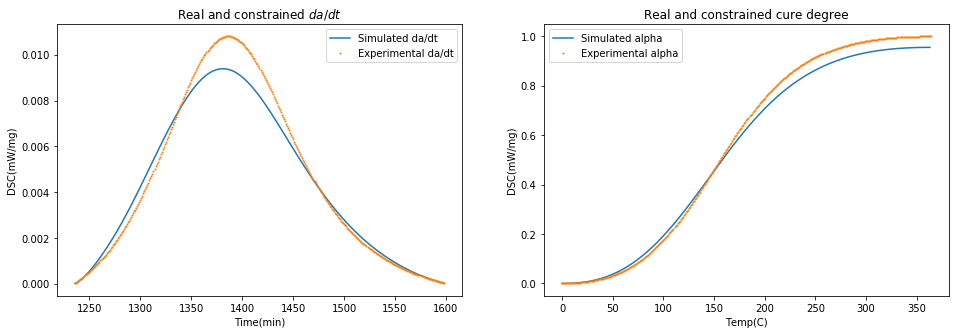

In [10]:
processed_df["pred_dalpha_dtime"] =  np.exp(lm_regr.predict(X))

pred_alpha = []
pred_alpha.append(0)
for i in range(len(processed_df)):
    pred_alpha.append(pred_alpha[-1] + 
                      processed_df.iloc[i][-1]*processed_df.iloc[i][1])#d_alpha * dt
    
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(processed_df["pred_dalpha_dtime"], label = "Simulated da/dt")
ax[0].plot(processed_df["dalpha_dtime"], ".",markersize=2, label = "Experimental da/dt")

ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].set_title('Real and constrained $da/dt$')
ax[0].legend()


ax[1].plot(pred_alpha, label = "Simulated alpha")
ax[1].plot(alpha, ".", markersize=2, label = "Experimental alpha")

ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].set_title('Real and constrained cure degree')
ax[1].legend()


It can be seen that the one used describes the behavior of the resin, but accuracy can be improved. Let's look at the numbers. We selected $R^2$ and **MSE** metrics

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pred = lm_regr.predict(X)

mse_lm=  mean_squared_error(y, pred)
r2_lm = r2_score(y, pred)


print("MSE for Prout-Tomkiense =", mse_lm)
print("R^2 for Prout-Tomkiense =", r2_lm)

MSE for Prout-Tomkiense = 0.014987874187918412
$R^2$ for Prout-Tomkiense = 0.9915726568648067


# Where is ML?

Now we got result for state of art method. Seems like it can be improved. Lest try different models and find one, which will fit data better. Fitst of all split data on target and features. Secondly have a look on our data.

In [29]:
processed_df.head()

,alpha,dtime,dalpha,dalpha_dtime,time,peak,temp,dtemp,dalpha_dtemp,pred_dalpha_dtime
1236,0.000009,0.6,0.000009,0.000016,12.37,0.003743,257.01857,0.00544,0.001742,0.000104
1237,0.000038,0.6,0.000029,0.000048,12.38,0.007540,257.02401,0.01230,0.002319,0.000108
1238,0.000087,0.6,0.000049,0.000081,12.39,0.011680,257.03631,0.01941,0.002501,0.000117
1239,0.000156,0.6,0.000070,0.000116,12.40,0.015847,257.05572,0.02649,0.002635,0.000131
1240,0.000247,0.6,0.000091,0.000151,12.41,0.020095,257.08221,0.03327,0.002731,0.000149


In [30]:
#X = processed_df.drop(columns="dalpha_dtime")#
X = processed_df[["alpha", "temp"]]
y = processed_df["dalpha_dtime"]

Text(0.5, 1.0, '$da/dt$ distribution')

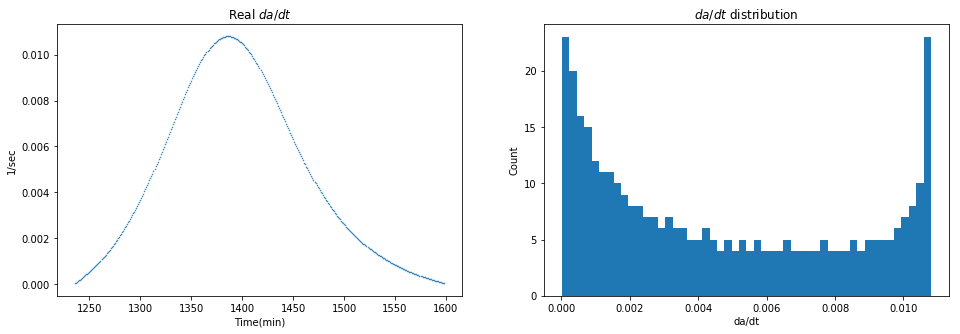

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(y, ".", markersize = 1, label = "Experimental da/dt")

ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('1/sec')
ax[0].set_title('Real $da/dt$')

ax[1].hist(y, bins = 50)
ax[1].set_xlabel("da/dt")
ax[1].set_ylabel('Count')
ax[1].set_title('$da/dt$ distribution')

The data are distributed as follows due to the fact that most of the time polymerization either starts or ends. Most polymerization is very fast.

For start, let's look how linear model fit data.

In [15]:
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2)

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

lr = linear_model.LinearRegression(fit_intercept=False, normalize=True)
lr.fit(X_train, y_train)

test_pred = lr.predict(X_test)
train_pred = lr.predict(X_train)

test_pred = lr.predict(X_test)
train_pred = lr.predict(X_train)

mse_lr_train =  mean_squared_error(y_train, train_pred)
mse_lr_test =  mean_squared_error(y_test, test_pred)

r2_score_train = r2_score(y_train, train_pred)
r2_score_test =  r2_score(y_test, test_pred)

print(mse_lr_test, mse_lr_train)
print(r2_score_test, r2_score_train)

1.2334010052915486e-05 1.3053300833859265e-05
0.021557600151755008 0.03676896850936229


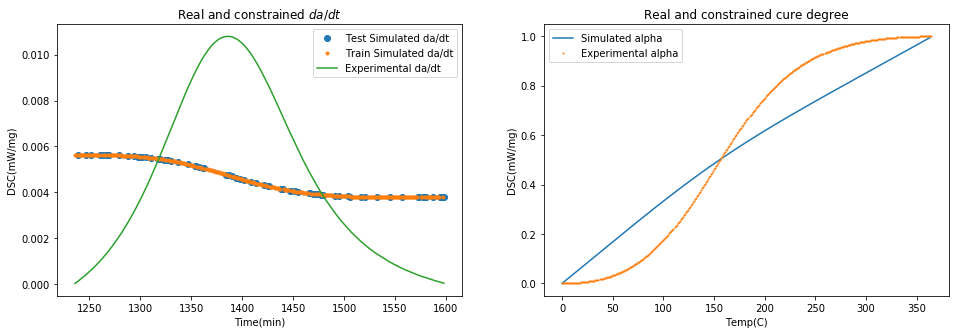

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

test_pred_visualised = pd.Series(test_pred, index=X_test.index)
train_pred_visualised = pd.Series(train_pred, index = X_train.index)

processed_df["pred_dalpha_dtime"] =  lr.predict(X)
pred_alpha = []
pred_alpha.append(0)
for i in range(len(processed_df)):
    pred_alpha.append(pred_alpha[-1] + 
                      processed_df.iloc[i][-1]*processed_df.iloc[i][1])#d_alpha * dt
    

ax[0].plot(test_pred_visualised,"o", label = "Test Simulated da/dt")
ax[0].plot(train_pred_visualised, ".", label = "Train Simulated da/dt")
ax[0].plot(y, label = "Experimental da/dt")

ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].set_title('Real and constrained $da/dt$')
ax[0].legend()

ax[1].plot(pred_alpha, label = "Simulated alpha")#TODO доделать
ax[1].plot(alpha, ".", markersize = 2, label = "Experimental alpha")

ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].set_title('Real and constrained cure degree')
ax[1].legend()

Naturally linear regression gave a bad result. The graph shows a bend. It appeared due to normalization is turned on Let's try add PolynomialFeatures transform.

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

poly = make_pipeline(PolynomialFeatures(degree=3), LinearRegression(fit_intercept=False))
poly.fit(X, y)

test_pred = poly.predict(X_test)
train_pred = poly.predict(X_train)

test_pred = poly.predict(X_test)
train_pred = poly.predict(X_train)

mse_lr_train =  mean_squared_error(y_train, train_pred)
mse_lr_test =  mean_squared_error(y_test, test_pred)

r2_score_train = r2_score(y_train, train_pred)
r2_score_test =  r2_score(y_test, test_pred)

print(mse_lr_test, mse_lr_train)# ошибку лучше считать по альфе, а не d_aplha (Y)
print(r2_score_test, r2_score_train)

4.996794110970108e-11 9.15535511515288e-11
0.9999960361024512 0.9999932440673333


This result is much better.

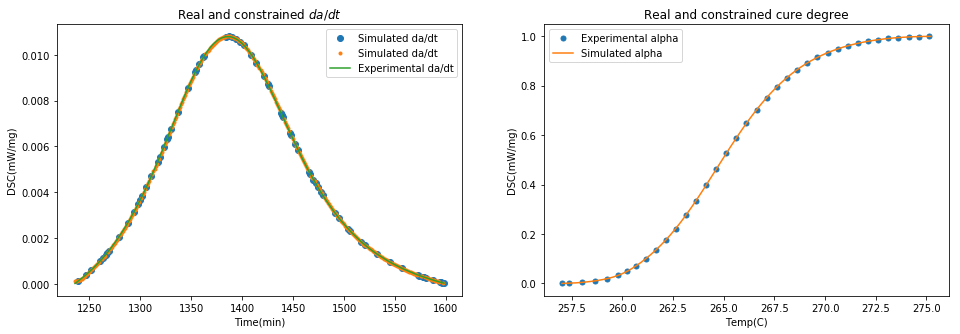

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

test_pred_visualised = pd.Series(test_pred, index=X_test.index)
train_pred_visualised = pd.Series(train_pred, index = X_train.index)

processed_df["pred_dalpha_dtime"] =  poly.predict(X)
pred_alpha = []
pred_alpha.append(0)
for i in range(len(processed_df)):
    pred_alpha.append(pred_alpha[-1] + 
                      processed_df.iloc[i][-1]*processed_df.iloc[i][1])#d_alpha * dt

ax[0].plot(test_pred_visualised, "o", label = "Simulated da/dt")
ax[0].plot(train_pred_visualised, ".", label = "Simulated da/dt")
ax[0].plot(y, label = "Experimental da/dt")
ax[0].legend()

ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].set_title('Real and constrained $da/dt$')

ax[1].plot(processed_df["temp"][::10], alpha[:len(processed_df["temp"]):10], ".", markersize = 10, label = "Experimental alpha")
ax[1].plot(processed_df["temp"], pred_alpha[:len(processed_df["temp"])], label = "Simulated alpha")

ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].set_title('Real and constrained cure degree')
ax[1].legend()

Plots show us that model fit our data great. We want to be honest, so lets find model error with cross validation.

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

mse_cross_val = cross_val_score(poly, X, y, cv = 4, scoring=make_scorer(mean_squared_error))
print("MSE cross valid score for poly model = ", mse_cross_val.mean())
r2_cross_val = cross_val_score(poly, X, y, cv = 4, scoring='r2')

print("R2 cross valid score for poly model = ", r2_cross_val.mean())

MSE cross valid score for poly model =  3.084849058831349e-06
R2 cross valid score for poly model =  -1.1118782407919032


Затем найдем грид серчем оптимальные параметры пайплайна - результат улучшится

In [21]:
from sklearn.model_selection import GridSearchCV

parameters = {'polynomialfeatures__degree' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}

clf = GridSearchCV(poly, parameters, cv=5, iid='False')
clf.fit(X, y)
print(clf.best_params_)

{'polynomialfeatures__degree': 4}


Видим, что оптимальный показатель степени для PolynomialFeatures равен тому, который мы выбрали изначально. 
Переучивать модель не нужно. Протестируем модель на более широком датасете.

Тут бы добавить гисторгамму ошибок для разных методов

In [22]:
#hist

[0.09091179, 0.08824617]
[0.10305, 0.10209]
[0.09012947, 0.08921658]


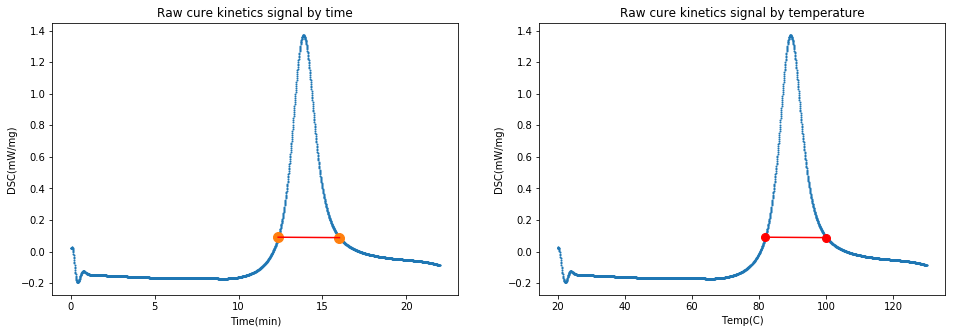

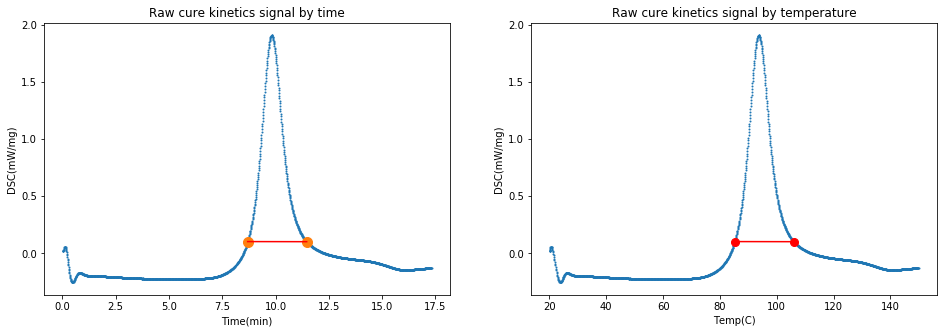

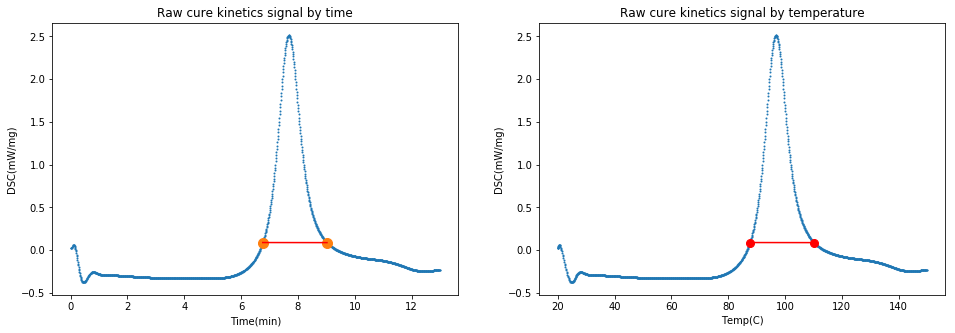

In [23]:
all_files = ['data/ExpDat_SK_Clear_resin_entalp5kpm_20-150.txt', 
             'data/ExpDat_SK_Clear_resin_entalp75kpm_20-150.txt',
             'data/ExpDat_SK_Clear_resin_entalp10kpm_20-150.txt',]
li = []
peaks = []

for filename in all_files:
    df = pd.read_csv(filename, sep='\t',comment='#')
    df.columns = ['Temp', 'Time', 'DSC', 'Sence']
    peak_start, peak_end = find_peak(df)
    peaks.append([peak_start, peak_end])
    peak, _ = calc_peak(df, peak_start, peak_end)
    alpha = calc_alpha(peak)
    li.append(extract_data(df, peak_start, peak_end, alpha))
    
combined_df = pd.concat(li, axis=0, ignore_index=True)#сбор датафреймов


Text(0.5, 1.0, 'Peaks for analysis')

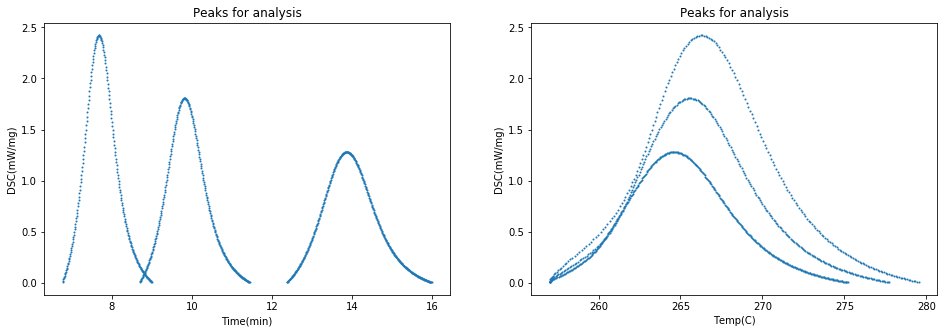

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(combined_df["time"], combined_df["peak"], ".", markersize=2, label = "Experimental da/dt")
ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].set_title('Peaks for analysis')

ax[1].plot(combined_df["temp"], combined_df["peak"], ".", markersize=2,  label = "Experimental da/dt")
ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].set_title('Peaks for analysis')

Text(0.5, 1.0, 'Real and constrained cure degree on temperature')

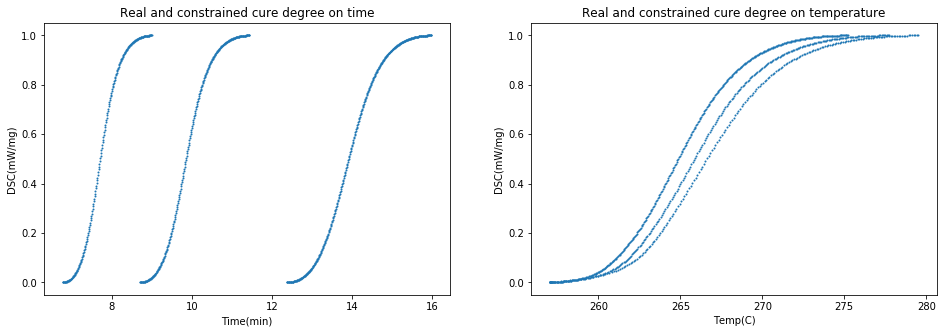

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(combined_df["time"], combined_df["alpha"], ".", markersize=2, label = "Experimental da/dt")
ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].set_title('Real and constrained cure degree on time')

ax[1].plot(combined_df["temp"], combined_df["alpha"], ".", markersize=2,  label = "Experimental da/dt")
ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].set_title('Real and constrained cure degree on temperature')

In [26]:
combined_df.head()

,alpha,dtime,dalpha,dalpha_dtime,time,peak,temp,dtemp,dalpha_dtemp
0,0.000009,0.6,0.000009,0.000016,12.37,0.003743,257.01857,0.00544,0.001742
1,0.000038,0.6,0.000029,0.000048,12.38,0.007540,257.02401,0.01230,0.002319
2,0.000087,0.6,0.000049,0.000081,12.39,0.011680,257.03631,0.01941,0.002501
3,0.000156,0.6,0.000070,0.000116,12.40,0.015847,257.05572,0.02649,0.002635
4,0.000247,0.6,0.000091,0.000151,12.41,0.020095,257.08221,0.03327,0.002731


Уравнение аррениуса для всех экспериментов

In [27]:
a = np.ones(combined_df['alpha'].count()) #собираем матрицу коэффицентов
b = np.array(-1 / (R * combined_df['temp']))
c = np.array(np.log(1 - combined_df['alpha']))
d = np.log(combined_df['alpha'])
X = np.vstack([a, b, c, d])
X = X.transpose()

y = np.log(combined_df['dalpha_dtime'])

lm_regr = linear_model.LinearRegression(fit_intercept=False, normalize=True)
lm_regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=True)

In [28]:
X = combined_df[["alpha", "temp"]]
y = combined_df["dalpha_dtime"]

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2)


poly.fit(X_train, y_train)

test_pred = poly.predict(X_test)
train_pred = poly.predict(X_train)

test_pred = poly.predict(X_test)
train_pred = poly.predict(X_train)

mse_lr_train =  mean_squared_error(y_train, train_pred)
mse_lr_test =  mean_squared_error(y_test, test_pred)

r2_score_train = r2_score(y_train, train_pred)
r2_score_test =  r2_score(y_test, test_pred)

print(mse_lr_test, mse_lr_train)# ошибку лучше считать по альфе, а не d_aplha (Y)
print(r2_score_test, r2_score_train)

2.075822712173738e-07 2.2205693594303e-07
0.9910693634274642 0.9912712011435673


Сравнение ошибки